### 1. Problem statement
---
The goal of this project is to check whether basic machine learning models can be helpful in predicting future prices of assets such as stocks, commodities and cryptocurrencies. We will choose very different assets for analysis, namely: INTEL (big value), VBK (ETF, small growth), China Yuchai International (micro value), coffee, silver, Bitcoin and Litecoin.

### 2. Data collection
---
We will use daily closing prices of the assets for the past five years for the analysis. Additionally, we will need some other economic data that may have an impact on the asset price. Let's choose the 5 Year Treasury yield, Federal Funds Effective Rate and the Euros to US Dollars exchange rate.

In [116]:
#!pip install yfinance
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [117]:
fed = web.DataReader('FEDFUNDS', 'fred')

In [118]:
yahoo_tickers = ['INTC','VBK','CYD','KC=F','SI=F','BTC-USD','LTC-USD','^FVX','EURUSD=X']
now = dt.datetime.now()
starting_date = str(int(now.strftime("%Y"))-5)+"-"+now.strftime("%m")+"-"+now.strftime("%d")
data = yf.download(yahoo_tickers,start=starting_date)

[*********************100%***********************]  9 of 9 completed


In [119]:
data = data['Close']
data.head()

,BTC-USD,CYD,EURUSD=X,INTC,KC=F,LTC-USD,SI=F,VBK,^FVX
Date,,,,,,,,,
2017-04-08,1175.949951,NaN,NaN,NaN,NaN,9.91621,NaN,NaN,NaN
2017-04-09,1187.869995,NaN,NaN,NaN,NaN,8.70985,NaN,NaN,NaN
2017-04-10,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900
2017-04-11,1205.010010,18.410000,1.059760,35.740002,140.199997,8.85383,18.233000,140.289993,1.832
2017-04-12,1200.369995,17.730000,1.061132,35.630001,138.300003,10.78560,18.278999,139.059998,1.830


In [120]:
data = pd.concat([data, fed],axis=1)
data.head(2)

,BTC-USD,CYD,EURUSD=X,INTC,KC=F,LTC-USD,SI=F,VBK,^FVX,FEDFUNDS
2017-04-08,1175.949951,NaN,NaN,NaN,NaN,9.91621,NaN,NaN,NaN,NaN
2017-04-09,1187.869995,NaN,NaN,NaN,NaN,8.70985,NaN,NaN,NaN,NaN


In [121]:
data['FEDFUNDS'].fillna(method='ffill', inplace=True)
data['FEDFUNDS'].fillna(method='bfill', inplace=True)

In [122]:
data.head()

,BTC-USD,CYD,EURUSD=X,INTC,KC=F,LTC-USD,SI=F,VBK,^FVX,FEDFUNDS
2017-04-08,1175.949951,NaN,NaN,NaN,NaN,9.91621,NaN,NaN,NaN,0.91
2017-04-09,1187.869995,NaN,NaN,NaN,NaN,8.70985,NaN,NaN,NaN,0.91
2017-04-10,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900,0.91
2017-04-11,1205.010010,18.410000,1.059760,35.740002,140.199997,8.85383,18.233000,140.289993,1.832,0.91
2017-04-12,1200.369995,17.730000,1.061132,35.630001,138.300003,10.78560,18.278999,139.059998,1.830,0.91


### 3. Data cleaning
We will remove the rows for Saturdays and Sundays as only cryptocurrencies are traded on the weekend. Next we will check to see if there are any other missing values.

In [123]:
data = data[data.index.dayofweek < 5]

In [124]:
data.isna().sum()

BTC-USD      0
CYD         46
EURUSD=X     3
INTC        46
KC=F        45
LTC-USD      0
SI=F        47
VBK         46
^FVX        46
FEDFUNDS     0
dtype: int64

The remaining missing values are related to public holidays. As we only have quotes for currencies and cryptocurrencies these days, let's remove them.

In [125]:
data.dropna(inplace=True)
print(data.isna().sum().sum())
print(data.shape)

0
(1255, 10)


In [126]:
data = data.rename(columns={'BTC-USD':'BTC','EURUSD=X':'EUR','KC=F':'COF','LTC-USD':'LTC','SI=F':'SIL','^FVX':'5YT','FEDFUNDS':'FED'})

### 4. Data exploration

Let's take a look at the movement of asset prices over time and the level of interest rates. Next, we will create a correlation map between the assets.

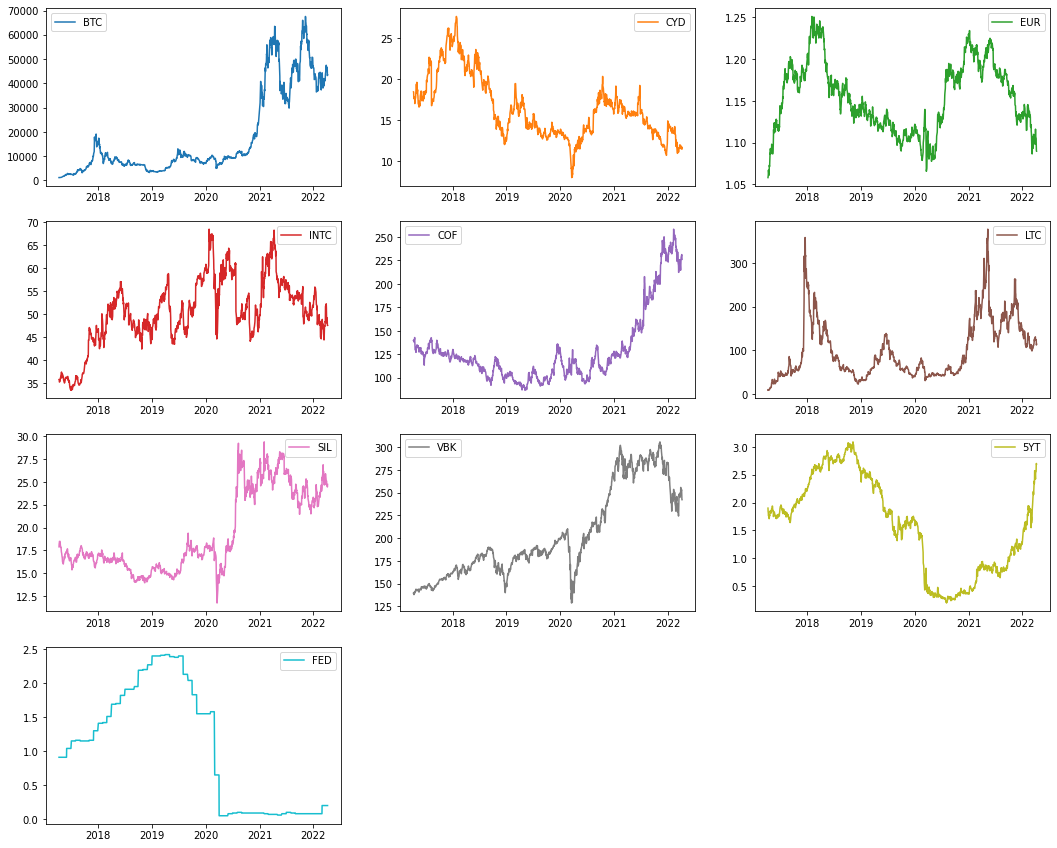

In [127]:
data.plot(subplots=True, sharex=False, layout=(4,3), figsize=(18,15))
plt.show()

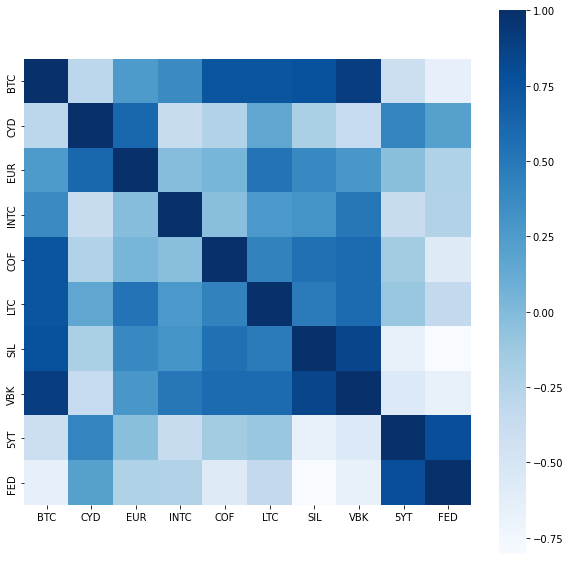

In [128]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),square=True,cmap="Blues")
plt.show()

We can see a logical relationship between interest rates and bond yields. Interestingly, the ETF of small growth companies is strongly correlated with other assets commonly regarded as speculative, such as silver or cryptocurrencies.

### 5. Data preparation
Let's prepare targets for machine learning models. Will price go up in next WINDOW days?

In [129]:
WINDOW = 5
assets_to_predict = ['BTC', 'CYD', 'INTC', 'COF', 'LTC', 'SIL', 'VBK']
for asset in assets_to_predict:
    data[asset + "_target"] = data.rolling(WINDOW+1).apply(lambda x: x.iloc[WINDOW] > x.iloc[0])[asset]

In [130]:
data.iloc[:8]

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-10,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-11,1205.010010,18.410000,1.059760,35.740002,140.199997,8.85383,18.233000,140.289993,1.832,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-12,1200.369995,17.730000,1.061132,35.630001,138.300003,10.78560,18.278999,139.059998,1.830,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-13,1169.280029,17.639999,1.067065,35.250000,138.899994,10.14950,18.489000,137.949997,1.764,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-17,1193.910034,17.809999,1.061053,35.480000,141.100006,10.42160,18.493000,139.539993,1.777,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-18,1211.670044,17.620001,1.064453,35.770000,142.899994,10.32010,18.250999,139.520004,1.710,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2017-04-19,1210.290039,17.040001,1.072869,35.910000,138.000000,9.65808,18.136000,140.080002,1.729,0.91,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2017-04-20,1229.079956,17.750000,1.071501,36.180000,131.649994,10.33490,17.992001,141.339996,1.772,0.91,1.0,1.0,1.0,0.0,0.0,0.0,1.0


Now we need to shift our targets backward (or features forward), because we want to predict the future outcome, not knowing current result.

In [131]:
for column in data:
  if "target" not in column:
    data[column]=data[column].shift(WINDOW)

In [132]:
data.head(WINDOW+2)

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-18,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2017-04-19,1205.010010,18.410000,1.059760,35.740002,140.199997,8.85383,18.233000,140.289993,1.832,0.91,1.0,0.0,1.0,0.0,1.0,0.0,0.0


Let's remove useless empty rows.

In [133]:
data = data.iloc[WINDOW:]
data.head(2)

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-18,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2017-04-19,1205.010010,18.410000,1.059760,35.740002,140.199997,8.85383,18.233000,140.289993,1.832,0.91,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [134]:
# Saving copy of data in case of offline work.
data.to_csv('Assets_prices_prediction.csv')

We will change nominal asset prices to daily percentage changes as price movements are more important than specific values.

In [ ]:
assets_to_change_to_pct = ['BTC', 'CYD', 'INTC', 'COF', 'LTC', 'SIL', 'VBK', 'EUR', '5YT']
data[assets_to_change_to_pct] = data[assets_to_change_to_pct].pct_change()

In [136]:
data = data[1:]
data.head(3)

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-19,0.015062,-0.003248,0.001473,-0.001676,0.002503,-0.007089,0.018945,0.005591,-0.035789,0.91,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2017-04-20,-0.003851,-0.036936,0.001295,-0.003078,-0.013552,0.218185,0.002523,-0.008768,-0.001092,0.91,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2017-04-21,-0.025900,-0.005076,0.005591,-0.010665,0.004338,-0.058977,0.011489,-0.007982,-0.036066,0.91,1.0,0.0,1.0,0.0,1.0,0.0,1.0


### 5. Application of models and their evaluation.

Let's perform train-test split and define features and targets.

In [137]:
train = data.iloc[:int(data.shape[0]*0.8)]
test = data.iloc[int(data.shape[0]*0.8):]
predictors = [column for column in data if 'target' not in column]
targets = [column for column in data if 'target' in column]
print(predictors, targets)

['BTC', 'CYD', 'EUR', 'INTC', 'COF', 'LTC', 'SIL', 'VBK', '5YT', 'FED'] ['BTC_target', 'CYD_target', 'INTC_target', 'COF_target', 'LTC_target', 'SIL_target', 'VBK_target']


Selecting machine learning algorithms .

In [138]:
models = []
models.append(("LR", LogisticRegression()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GRAD', GradientBoostingClassifier()))

As we have the ability to open both long and short in the financial markets, we will choose accuracy as a metric to compare models.

In [139]:
results = []
for target in targets:
  for name, model in models:
    model.fit(train[predictors], train[target])
    predictions = model.predict(test[predictors])
    accuracy = accuracy_score(test[target], predictions)
    results.append((target.strip("_target"), name, accuracy))
print(results)

[('BTC', 'LR', 0.46), ('BTC', 'TREE', 0.5), ('BTC', 'RF', 0.488), ('BTC', 'KNN', 0.54), ('BTC', 'AB', 0.448), ('BTC', 'GRAD', 0.476), ('CYD', 'LR', 0.4), ('CYD', 'TREE', 0.42), ('CYD', 'RF', 0.552), ('CYD', 'KNN', 0.52), ('CYD', 'AB', 0.572), ('CYD', 'GRAD', 0.584), ('INTC', 'LR', 0.444), ('INTC', 'TREE', 0.512), ('INTC', 'RF', 0.468), ('INTC', 'KNN', 0.476), ('INTC', 'AB', 0.512), ('INTC', 'GRAD', 0.476), ('COF', 'LR', 0.588), ('COF', 'TREE', 0.524), ('COF', 'RF', 0.472), ('COF', 'KNN', 0.46), ('COF', 'AB', 0.468), ('COF', 'GRAD', 0.488), ('LTC', 'LR', 0.484), ('LTC', 'TREE', 0.48), ('LTC', 'RF', 0.488), ('LTC', 'KNN', 0.488), ('LTC', 'AB', 0.5), ('LTC', 'GRAD', 0.46), ('SIL', 'LR', 0.552), ('SIL', 'TREE', 0.524), ('SIL', 'RF', 0.528), ('SIL', 'KNN', 0.536), ('SIL', 'AB', 0.568), ('SIL', 'GRAD', 0.556), ('VBK', 'LR', 0.52), ('VBK', 'TREE', 0.508), ('VBK', 'RF', 0.512), ('VBK', 'KNN', 0.552), ('VBK', 'AB', 0.532), ('VBK', 'GRAD', 0.512)]


In [140]:
results_df = pd.DataFrame(results, columns=['Target','Model','Accuracy'])
results_df.head(3)

,Target,Model,Accuracy
0,BTC,LR,0.460
1,BTC,TREE,0.500
2,BTC,RF,0.488


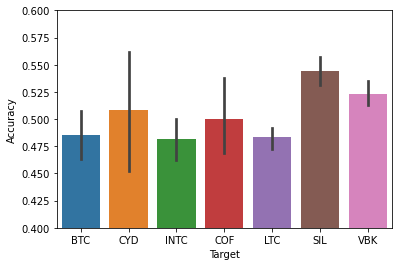

In [141]:
plt.ylim(0.4,0.6)
sns.barplot(x=results_df['Target'], y=results_df['Accuracy'])
plt.show()

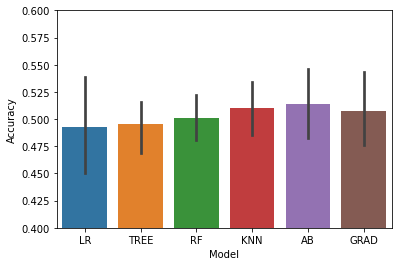

In [142]:
plt.ylim(0.4,0.6)
sns.barplot(x=results_df['Model'], y=results_df['Accuracy'])
plt.show()

In [143]:
results_df.sort_values('Accuracy', ascending=False).head(10)

,Target,Model,Accuracy
18,COF,LR,0.588
11,CYD,GRAD,0.584
10,CYD,AB,0.572
34,SIL,AB,0.568
35,SIL,GRAD,0.556
39,VBK,KNN,0.552
8,CYD,RF,0.552
30,SIL,LR,0.552
3,BTC,KNN,0.540
33,SIL,KNN,0.536


In [144]:
results_df.Accuracy.mean()

0.5035238095238095

In [147]:
results_df[results_df.Target == 'SIL'].Accuracy.mean()

0.544

### 6. Conclusions
After several attempts with a different WINDOW parameter, we are able to observe the following conclusions:
1. Generally, the machine learning models we have studied are better at predicting speculative assets.
2. Without the performance of hyperparameter tuning, the models yield only marginally better results than random choice.
3. In some settings (e.g. window = 5, asset = SIL) we achieve very good predictability and this may be the starting point for further research.
